In [1]:
import pandas as pd
import numpy as np
import os, joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import get_scorer
from sklearn.utils import compute_sample_weight
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb

from helper_func import train_pre_data, DFToDictTransformer

import warnings
warnings.filterwarnings("ignore")


/Users/royabitbol/anaconda3/envs/mafat/lib/python3.10/site-packages/lightgbm/__init__.py:40: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "
/Users/royabitbol/anaconda3/envs/mafat/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# experiment_metadata = dict(
#     prediction_column='y_track1',
#     holdout_size=0.1,
#     scoring='roc_auc',
#     random_state=33,
#     include_only_estimators=['RandomForestClassifierEstimator', 'DecisionTreeClassifierEstimator', 'LogisticRegressionEstimator', 'ExtraTreesClassifierEstimator', 'XGBClassifierEstimator', 'LGBMClassifierEstimator', 'SnapDecisionTreeClassifierEstimator', 'SnapRandomForestClassifierEstimator', 'SnapLogisticRegressionEstimator', 'SnapSVMClassifierEstimator', 'GradientBoostingClassifierEstimator'],
#     train_sample_columns_index_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
#     positive_label='1.0',
# )

RSSI_value_selection = "Average" #@param ["RSSI_Left","RSSI_Right","Min","Max","Average"]
window_size = 360 #@param {type:"integer"}
window_stride = 360 #@param {type:"integer"}
create_validation_set = True
data = pd.read_csv('../../data/mafat_wifi_challenge_training_set_v1.csv', low_memory=False)


In [3]:
if create_validation_set:
    data_val = data[data['Room_Num']==2]
    data.drop(data[data['Room_Num']==2].index,inplace=True)
    data_val_x, data_val_y, raw_val_x = train_pre_data(data_val, RSSI_value_selection, window_size, window_stride)
    data_val_y_track1 = data_val_y.copy()
    data_val_y_track1.loc[data_val_y>0] = 1

data_train_x, data_train_y, raw_train_x = train_pre_data(data, RSSI_value_selection, window_size, window_stride)


data_train_y_track1 = data_train_y.copy()
data_train_y_track1.loc[data_train_y>0] = 1

In [4]:
# clustering = SpectralClustering(n_clusters=8, assign_labels='discretize', random_state=42).fit(data_train_x)
# clustering.labels_

In [5]:
# clustering_qr = SpectralClustering(n_clusters=8, assign_labels='cluster_qr', random_state=42).fit(data_train_x)
# clustering_qr.labels_

In [6]:
from sklearn.cluster import MiniBatchKMeans

In [18]:
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100, max_iter=100).fit(data_train_x)
kmeans.cluster_centers_

array([[-4.60396660e+01,  9.78630970e-01,  8.73477882e-02,
         4.67223382e+00,  3.66388309e+00, -3.54070981e+00,
         1.27935985e-04,  5.16987979e-01, -4.75106048e-01,
         7.20459290e+00,  1.14502707e-01,  0.00000000e+00,
         5.01802319e-01,  4.07306889e+00,  3.80375783e+00,
         4.84638135e-01,  0.00000000e+00,  9.49501820e-01,
         3.80375783e+00,  2.70498956e+02,  5.97703549e+00,
         8.54697286e+00,  1.22899042e+00,  3.70146138e+00],
       [-4.31534733e+01,  2.34675664e+00,  3.12088252e-01,
         1.02471729e+01,  7.44103393e+00, -7.19063005e+00,
        -1.75500965e-04,  1.25332373e+00,  2.58731585e-01,
         1.46316640e+01,  4.22052821e-01,  3.23101777e-03,
         1.17295089e+00,  7.95153473e+00,  7.22374798e+00,
         1.80065518e+00,  1.33037157e+00,  1.71206089e+00,
         7.21001616e+00,  1.17428110e+02,  2.09822294e+01,
         3.27415186e+01,  1.63522272e+00,  9.31663974e+00],
       [-4.74327957e+01,  2.02358784e-01,  2.95683551e

In [8]:
len(kmeans.cluster_centers_)

8

In [9]:
len(kmeans.labels_)

5108

In [10]:
def get_embedded_data(X, method='pca'):
    if method == 'pca':
        from sklearn.decomposition import PCA
        return PCA(n_components=2).fit_transform(X)
    elif method == 'tsne':
        from sklearn.manifold import TSNE
        return TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
    else:
        print('embedding method not implemented. bye')
        exit()

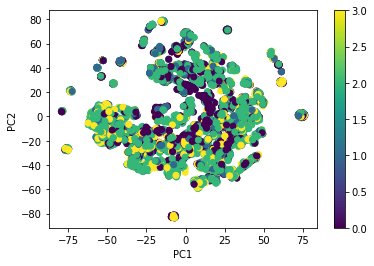

In [11]:
M = get_embedded_data(data_train_x, method='tsne')
plt.scatter(M[:, 0], M[:, 1], c=data_train_y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

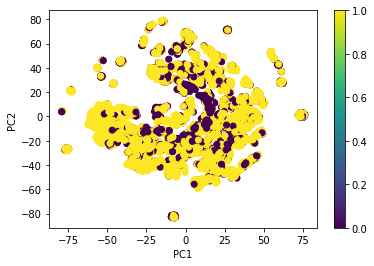

In [12]:
plt.scatter(M[:, 0], M[:, 1], c=data_train_y_track1, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

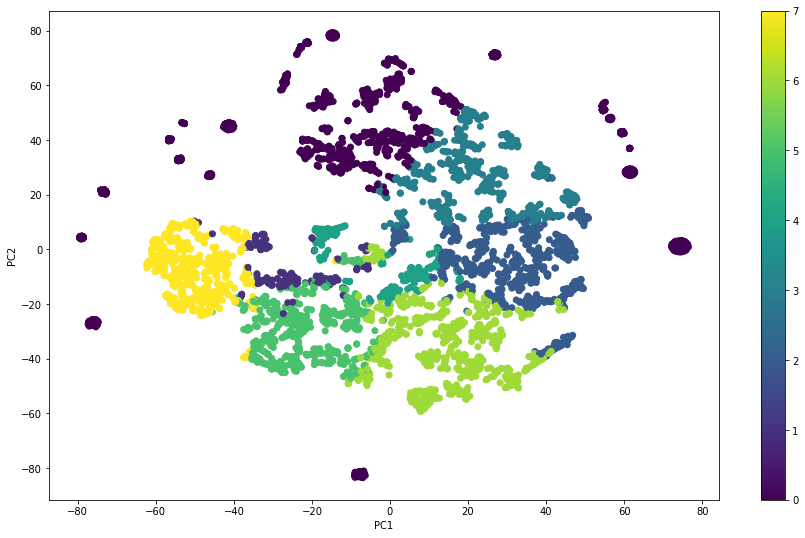

In [13]:
# 8 Kernels
plt.rcParams['figure.figsize'] = [15, 9]
plt.scatter(M[:, 0], M[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

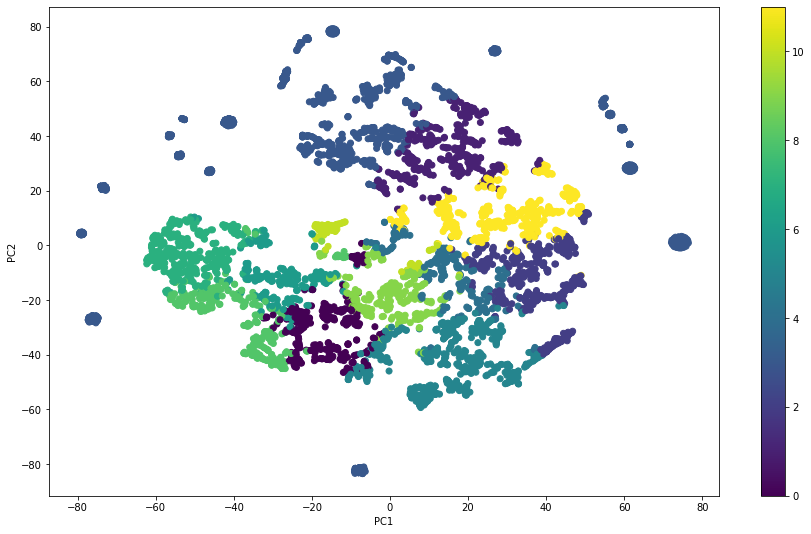

In [15]:
#12 Kernels
plt.rcParams['figure.figsize'] = [15, 9]
plt.scatter(M[:, 0], M[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

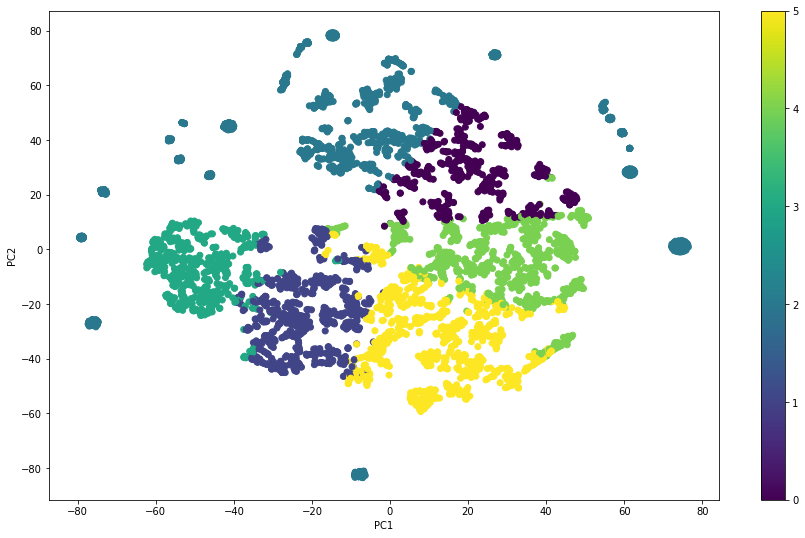

In [17]:
# 6 Kernels
plt.rcParams['figure.figsize'] = [15, 9]
plt.scatter(M[:, 0], M[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

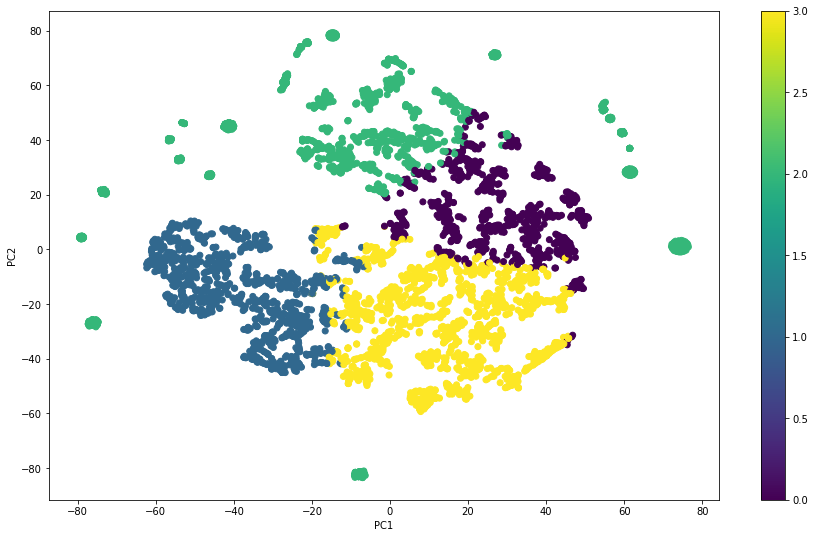

In [19]:
# 4 Kernels
plt.rcParams['figure.figsize'] = [15, 9]
plt.scatter(M[:, 0], M[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

In [4]:
# train_X, test_X, train_y, test_y = train_test_split(data_train_x, data_train_y_track1, test_size=0.25, random_state=42)

In [5]:
ct = make_column_transformer(
      (StandardScaler(), make_column_selector(dtype_include=np.number)))

In [6]:


lgbm_classifier = LGBMClassifier(
    class_weight="balanced", n_estimators=100, random_state=33
)

xgbc = xgb.XGBClassifier()



In [7]:
dict_vec_transformer = DV(sparse=False)
df_to_dict_transformer = DFToDictTransformer()
scorer = get_scorer('roc_auc')
sample_weight = compute_sample_weight('balanced', data_train_y_track1)

In [15]:
pipeline = make_pipeline(
    ct, 
    # dict_vec_transformer,
    lgbm_classifier,
    # xgbc
)

In [16]:
# pipeline.fit(train_X.to_dict('records'), train_y.values.ravel())
# pipeline.fit(train_X, train_y)

# pipeline.fit(data_train_x, data_train_y_track1, xgbclassifier__sample_weight=sample_weight)
pipeline.fit(data_train_x, data_train_y_track1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1365db3a0>)])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', random_state=33))])

In [17]:
# score = scorer(pipeline, test_X, test_y)
# print(score)

In [18]:
score = scorer(pipeline, data_val_x, data_val_y_track1)
print(score)

0.7591862845445241


In [19]:
# pipeline.predict(test_X)

In [20]:
# model_filename = os.path.join(os.getcwd(), 'mafat_xgb_no_sw.joblib')
# _ = joblib.dump(pipeline, model_filename)
# print(f"New model has been written to {model_filename}")

In [21]:
# union = make_union(pipeline_0, pipeline_1)
# numpy_permute_array = NumpyPermuteArray(
#     axis=0,
#     permutation_indices=[
#         0, 3, 4, 5, 9, 11, 13, 18, 20, 21, 23, 1, 2, 6, 7, 8, 10, 12, 14, 15,
#         16, 17, 19, 22,
#     ],
# )
# ta1 = TA1(
#     fun=np.square,
#     name="square",
#     datatypes=["numeric"],
#     feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
#     col_names=[
#         "max_RSSI", "std_RSSI", "skew_RSSI", "max_sub_min_RSSI",
#         "max_RSSI_diffs", "min_RSSI_diffs", "mean_RSSI_diffs",
#         "std_RSSI_diffs", "skew_RSSI_diffs", "max_sub_min_RSSI_diffs",
#         "mean_RSSI_diffs_abs", "median_RSSI_diffs_abs", "std_RSSI_diffs_abs",
#         "max_sub_min_RSSI_diffs_abs", "max_RSSI_median_dist",
#         "mean_RSSI_median_dist", "median_RSSI_median_dist",
#         "std_RSSI_median_dist", "max_sub_min_RSSI_median_dist",
#         "max_count_same_value_RSSI", "RSSI_peaks", "RSSI_diffs_peaks",
#         "peak_ratio_diffs_RSSI", "RSSI_values_count",
#     ],
#     col_dtypes=[
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#     ],
# )
# fs1_0 = FS1(
#     cols_ids_must_keep=range(0, 24),
#     additional_col_count_to_keep=20,
#     ptype="classification",
# )
# t_gen = TGen(
#     fun=autoai_libs.cognito.transforms.transform_extras.NXOR,
#     name="nxor",
#     arg_count=2,
#     datatypes_list=[["numeric"], ["numeric"]],
#     feat_constraints_list=[
#         [autoai_libs.utils.fc_methods.is_not_categorical],
#         [autoai_libs.utils.fc_methods.is_not_categorical],
#     ],
#     col_names=[
#         "max_RSSI", "std_RSSI", "skew_RSSI", "max_sub_min_RSSI",
#         "max_RSSI_diffs", "min_RSSI_diffs", "mean_RSSI_diffs",
#         "std_RSSI_diffs", "skew_RSSI_diffs", "max_sub_min_RSSI_diffs",
#         "mean_RSSI_diffs_abs", "median_RSSI_diffs_abs", "std_RSSI_diffs_abs",
#         "max_sub_min_RSSI_diffs_abs", "max_RSSI_median_dist",
#         "mean_RSSI_median_dist", "median_RSSI_median_dist",
#         "std_RSSI_median_dist", "max_sub_min_RSSI_median_dist",
#         "max_count_same_value_RSSI", "RSSI_peaks", "RSSI_diffs_peaks",
#         "peak_ratio_diffs_RSSI", "RSSI_values_count", "square(max_RSSI)",
#         "square(std_RSSI)", "square(skew_RSSI)", "square(max_sub_min_RSSI)",
#         "square(max_RSSI_diffs)", "square(mean_RSSI_diffs)",
#         "square(std_RSSI_diffs)", "square(skew_RSSI_diffs)",
#         "square(max_sub_min_RSSI_diffs)", "square(mean_RSSI_diffs_abs)",
#         "square(max_sub_min_RSSI_diffs_abs)", "square(max_RSSI_median_dist)",
#         "square(mean_RSSI_median_dist)", "square(std_RSSI_median_dist)",
#         "square(max_sub_min_RSSI_median_dist)",
#         "square(max_count_same_value_RSSI)", "square(RSSI_peaks)",
#         "square(RSSI_diffs_peaks)", "square(peak_ratio_diffs_RSSI)",
#         "square(RSSI_values_count)",
#     ],
#     col_dtypes=[
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
#         np.dtype("float32"), np.dtype("float32"),
#     ],
# )
# fs1_1 = FS1(
#     cols_ids_must_keep=range(0, 24),
#     additional_col_count_to_keep=20,
#     ptype="classification",
# )